# CNN_7channel

Abstract:
- single channel: band_avg
- CNN, small net

Result:
- Kaggle score: 0.2229

References:
- https://www.kaggle.com/ivalmian/simple-svd-xgboost-baseline-lb-35
- https://www.kaggle.com/arieltci/a-keras-prototype-0-21174-on-pl

## 1. Preprocess

### Import pkgs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import log_loss, accuracy_score
from IPython.display import display

%matplotlib inline

In [2]:
import os
import time
import zipfile
import lzma
import pickle
from PIL import Image
from shutil import copy2

### Run name

In [3]:
project_name = 'SC_Iceberg_Classifier'
step_name = 'CNN_4channel'
date_str = time.strftime("%Y%m%d", time.localtime())
time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime())
run_name = project_name + '_' + step_name + '_' + time_str
print('run_name: ' + run_name)

run_name: SC_Iceberg_Classifier_CNN_4channel_20171105_153935


### Basic folders

In [4]:
cwd = os.getcwd()
input_path = os.path.join(cwd, 'input')
log_path = os.path.join(cwd, 'log')
model_path = os.path.join(cwd, 'model')
output_path = os.path.join(cwd, 'output')
print('input_path: ' + input_path)
print('log_path: ' + log_path)
print('model_path: ' + model_path)
print('output_path: ' + output_path)

input_path: D:\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\input
log_path: D:\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\log
model_path: D:\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\model
output_path: D:\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\output


### Load data

In [5]:
sample_submission_path = os.path.join(input_path, 'sample_submission.csv')
sample_submission = pd.read_csv(sample_submission_path)
print(sample_submission.shape)
sample_submission.head(2)

(8424, 2)


,id,is_iceberg
0,5941774d,0.5
1,4023181e,0.5


In [6]:
is_iceberg_path = os.path.join(input_path, 'is_iceberg.p')

y_data = pickle.load(open(is_iceberg_path, mode='rb'))

print(y_data.shape)

(1604,)


In [7]:
%%time
#Load orignal data
inc_angle_data_path = os.path.join(input_path, 'inc_angle_data.p')
inc_angle_test_path = os.path.join(input_path, 'inc_angle_test.p')

inc_angle_data = pickle.load(open(inc_angle_data_path, mode='rb'))
inc_angle_test = pickle.load(open(inc_angle_test_path, mode='rb'))

print(inc_angle_data.shape)
print(inc_angle_test.shape)

(1604,)
(8424,)
Wall time: 14 ms


In [8]:
%%time
#Load orignal data
band1_data_path = os.path.join(input_path, 'band1_data.p')
band2_data_path = os.path.join(input_path, 'band2_data.p')
band_avg_data_path = os.path.join(input_path, 'band_avg_data.p')
band1_test_path = os.path.join(input_path, 'band1_test.p')
band2_test_path = os.path.join(input_path, 'band2_test.p')
band_avg_test_path = os.path.join(input_path, 'band_avg_test.p')

band1_data = pickle.load(open(band1_data_path, mode='rb'))
band2_data = pickle.load(open(band2_data_path, mode='rb'))
band_avg_data = pickle.load(open(band_avg_data_path, mode='rb'))
band1_test = pickle.load(open(band1_test_path, mode='rb'))
band2_test = pickle.load(open(band2_test_path, mode='rb'))
band_avg_test = pickle.load(open(band_avg_test_path, mode='rb'))

print(band1_data.shape)
print(band2_data.shape)
print(band_avg_data.shape)
print(band1_test.shape)
print(band2_test.shape)
print(band_avg_test.shape)

(1604, 75, 75)
(1604, 75, 75)
(1604, 75, 75)
(8424, 75, 75)
(8424, 75, 75)
(8424, 75, 75)
Wall time: 4.21 s


In [9]:
%%time
#Load orignal data
band1_data_edges_path = os.path.join(input_path, 'band1_data_edges.p')
band2_data_edges_path = os.path.join(input_path, 'band2_data_edges.p')
band_avg_data_edges_path = os.path.join(input_path, 'band_avg_data_edges.p')
band1_test_edges_path = os.path.join(input_path, 'band1_test_edges.p')
band2_test_edges_path = os.path.join(input_path, 'band2_test_edges.p')
band_avg_test_edges_path = os.path.join(input_path, 'band_avg_test_edges.p')

band1_data_edges = pickle.load(open(band1_data_edges_path, mode='rb'))
band2_data_edges = pickle.load(open(band2_data_edges_path, mode='rb'))
band_avg_data_edges = pickle.load(open(band_avg_data_edges_path, mode='rb'))
band1_test_edges = pickle.load(open(band1_test_edges_path, mode='rb'))
band2_test_edges = pickle.load(open(band2_test_edges_path, mode='rb'))
band_avg_test_edges = pickle.load(open(band_avg_test_edges_path, mode='rb'))

print(band1_data_edges.shape)
print(band2_data_edges.shape)
print(band_avg_data_edges.shape)
print(band1_test_edges.shape)
print(band2_test_edges.shape)
print(band_avg_test_edges.shape)

(1604, 75, 75)
(1604, 75, 75)
(1604, 75, 75)
(8424, 75, 75)
(8424, 75, 75)
(8424, 75, 75)
Wall time: 4.72 s


In [10]:
%%time
x_data = np.concatenate([band1_data[:, :, :, np.newaxis],
                         band2_data[:, :, :, np.newaxis],
                         band_avg_data[:, :, :, np.newaxis],
                         band1_data_edges[:, :, :, np.newaxis],
                         band2_data_edges[:, :, :, np.newaxis],
                         band_avg_data_edges[:, :, :, np.newaxis]], axis=-1)
print(x_data.shape)
x_test = np.concatenate([band1_test[:, :, :, np.newaxis],
                         band2_test[:, :, :, np.newaxis],
                         band_avg_test[:, :, :, np.newaxis],
                         band1_test_edges[:, :, :, np.newaxis],
                         band2_test_edges[:, :, :, np.newaxis],
                         band_avg_test_edges[:, :, :, np.newaxis]], axis=-1)
print(x_test.shape)

(1604, 75, 75, 6)
(8424, 75, 75, 6)
Wall time: 4.05 s


In [11]:
x_train, x_val, inc_angle_train, inc_angle_val, y_train, y_val = train_test_split(x_data, inc_angle_data, y_data, test_size=0.15, shuffle=True, random_state=31)
print(x_train.shape)
print(x_val.shape)
print(inc_angle_train.shape)
print(inc_angle_val.shape)
print(y_train.shape)
print(y_val.shape)

(1363, 75, 75, 6)
(241, 75, 75, 6)
(1363,)
(241,)
(1363,)
(241,)


## 2. Build model

In [12]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization, Input
from keras.layers.merge import Concatenate
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, TensorBoard

Using TensorFlow backend.


In [13]:
def build_model():
    bn_model = 0
    p_activation = "relu"
    input_1 = Input(shape=(75, 75, 6), name="bands")
    input_2 = Input(shape=[1], name="angle")
    
    img_1 = Conv2D(32, kernel_size = (3,3), activation=p_activation)(input_1)
    img_1 = BatchNormalization()(img_1)
    img_1 = Conv2D(32, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = BatchNormalization()(img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.2)(img_1)
    
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = BatchNormalization()(img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = BatchNormalization()(img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.2)(img_1)
    
    img_1 = Conv2D(128, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = BatchNormalization()(img_1)
    img_1 = Conv2D(128, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = BatchNormalization()(img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.2)(img_1)

    img_1 = GlobalMaxPooling2D() (img_1)
    
#     img_2 = Conv2D(128, kernel_size = (3,3), activation=p_activation)(input_1)
#     img_2 = BatchNormalization()(img_2)
#     img_2 = MaxPooling2D((2,2)) (img_2)
#     img_2 = Dropout(0.2)(img_2)
#     img_2 = GlobalMaxPooling2D() (img_2)
    
    angle = BatchNormalization()(input_2)
    img_concat = (Concatenate()([img_1, angle]))
    
#     img_concat = Concatenate([img_1, input_2])
    
    dense_ayer = Dense(1024, activation=p_activation)(img_concat)
    dense_ayer = BatchNormalization()(dense_ayer)
    dense_ayer = Dropout(0.5)(dense_ayer)
    dense_ayer = Dense(1024, activation=p_activation)(dense_ayer)
    dense_ayer = BatchNormalization()(dense_ayer)
    dense_ayer = Dropout(0.5)(dense_ayer)
    output = Dense(1, activation="sigmoid")(dense_ayer)
    
    model = Model([input_1,input_2],  output)
#     optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer = Adam(lr=1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [14]:
# def build_model():
#     model = Sequential()

#     model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu',
#                      input_shape = (75, 75, 3)))
#     model.add(BatchNormalization())
#     model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D(strides=(2,2)))
#     model.add(Dropout(0.25))

#     model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D(strides=(2,2)))
#     model.add(Dropout(0.25))

#     model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D(strides=(2,2)))
#     model.add(Dropout(0.25))
    
#     model.add(Flatten())
#     model.add(Dense(1024, activation='relu'))
#     model.add(Dropout(0.25))
#     model.add(Dense(1024, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(units = 1, activation = 'sigmoid'))

#     model.compile(optimizer = Adam(lr=1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
#     return model

In [15]:
model = build_model()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
bands (InputLayer)               (None, 75, 75, 6)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 73, 73, 32)    1760        bands[0][0]                      
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 73, 73, 32)    128         conv2d_1[0][0]                   
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 71, 71, 32)    9248        batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [16]:
def saveModel(model, run_name):
    cwd = os.getcwd()
    modelPath = os.path.join(cwd, 'model')
    if not os.path.isdir(modelPath):
        os.mkdir(modelPath)
    weigthsFile = os.path.join(modelPath, run_name + '.h5')
    model.save(weigthsFile)
saveModel(model, 'saveModel_test')

In [17]:
# def get_lr(x):
#     lr = round(1e-3 * 0.9 ** x, 6)
#     if lr < 1e-4:
#         lr = 1e-4
#     print(lr, end='  ')
#     return lr

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

log_dir = os.path.join(log_path, run_name)
print('log_dir:' + log_dir)
tensorBoard = TensorBoard(log_dir=log_dir)

log_dir:D:\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\log\SC_Iceberg_Classifier_CNN_4channel_20171105_153935


In [18]:
hist = model.fit([x_train, inc_angle_train], y_train, 
                 batch_size = 8, 
                 verbose= 1,
                 epochs = 50, #1 for ETA, 0 for silent
                 validation_data=([x_val, inc_angle_val], y_val),
                 callbacks=[annealer, tensorBoard])

Train on 1363 samples, validate on 241 samples
Epoch 1/50
1363/1363 [==============================] - 29s - loss: 0.8447 - acc: 0.6838 - val_loss: 0.4645 - val_acc: 0.7427
Epoch 2/50
1363/1363 [==============================] - 24s - loss: 0.6069 - acc: 0.7432 - val_loss: 0.7700 - val_acc: 0.6556
Epoch 3/50
1363/1363 [==============================] - 25s - loss: 0.4855 - acc: 0.7997 - val_loss: 0.9728 - val_acc: 0.6680
Epoch 4/50
1363/1363 [==============================] - 25s - loss: 0.4909 - acc: 0.7850 - val_loss: 0.3985 - val_acc: 0.8382
Epoch 5/50
1363/1363 [==============================] - 25s - loss: 0.4112 - acc: 0.8202 - val_loss: 0.4246 - val_acc: 0.8050
Epoch 6/50
1363/1363 [==============================] - 25s - loss: 0.3857 - acc: 0.8386 - val_loss: 0.3089 - val_acc: 0.8423
Epoch 7/50
1363/1363 [==============================] - 25s - loss: 0.4089 - acc: 0.8327 - val_loss: 0.3153 - val_acc: 0.8631
Epoch 8/50
1363/1363 [==============================] - 25s - loss: 0.3

In [19]:
final_loss, final_acc = model.evaluate([x_val, inc_angle_val], y_val, verbose=1)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

241/241 [==============================] - 2s     
Final loss: 0.2978, final accuracy: 0.9087


In [20]:
val_prob1 = model.predict([x_val, inc_angle_val])

# print('Val log_loss: {}'.format(log_loss(y_val, val_prob1)))
val_prob1_limit = np.clip(val_prob1, 0.00005, 0.99995)
loss = log_loss(y_val, val_prob1_limit)
print('Val log_loss: {}'.format(loss))

val_prob1_limit = np.clip(val_prob1_limit, 0.05, 0.95)
loss = log_loss(y_val, val_prob1_limit)
print('Val log_loss: {}'.format(loss))

Val log_loss: 0.29782024815446007
Val log_loss: 0.2688175389288125


In [21]:
final_acc_str = str(int(loss*10000))
run_name_acc = project_name + '_' + step_name + '_' + time_str + '_' + final_acc_str
print(run_name_acc)

SC_Iceberg_Classifier_CNN_4channel_20171105_153935_2688


In [22]:
histories = pd.DataFrame(hist.history)
histories['epoch'] = hist.epoch
print(histories.columns)
histories_file = os.path.join(model_path, run_name_acc + '.csv')
histories.to_csv(histories_file, index=False)

Index(['acc', 'loss', 'val_acc', 'val_loss', 'epoch'], dtype='object')


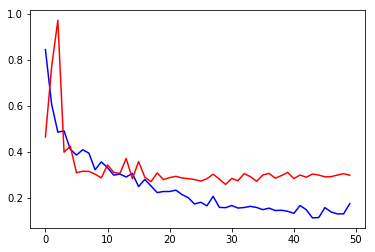

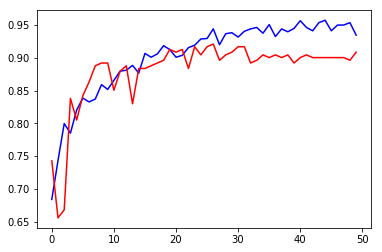

In [23]:
plt.plot(histories['loss'], color='b')
plt.plot(histories['val_loss'], color='r')
plt.show()
plt.plot(histories['acc'], color='b')
plt.plot(histories['val_acc'], color='r')
plt.show()

In [24]:
saveModel(model, run_name_acc)

## 3. Predict

In [25]:
if not os.path.exists(output_path):
    os.mkdir(output_path)
pred_file = os.path.join(output_path, run_name_acc + '.csv')
print(pred_file)

D:\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\output\SC_Iceberg_Classifier_CNN_4channel_20171105_153935_2688.csv


In [26]:
test_prob = model.predict([x_test, inc_angle_test])
print(test_prob.shape)
print(test_prob[0:2])
test_prob = np.clip(test_prob, 0.05, 0.95)
print(test_prob.shape)
print(test_prob[0:2])

(8424, 1)
[[ 0.03289312]
 [ 0.10460932]]
(8424, 1)
[[ 0.05      ]
 [ 0.10460932]]


In [27]:
sample_submission['is_iceberg'] = test_prob
print(sample_submission[0:2])
print(sample_submission.shape)
sample_submission.to_csv(pred_file, index=False)

         id  is_iceberg
0  5941774d    0.050000
1  4023181e    0.104609
(8424, 2)


In [28]:
print(run_name_acc)
print('Done!')

SC_Iceberg_Classifier_CNN_4channel_20171105_153935_2688
Done!
